# DL1 Assignment2 - Q1.1 - Ryan Ott

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [1]:
!pip install timm

In [2]:
from time import sleep
import timm
import numpy as np
import torch
from torch import nn
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable

%matplotlib inline

In [3]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
# ? Answer: We would run out of memory
model_defs = [
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
    models.vit_b_32,
    vit_s_8,
]

# Accuracies per model
model_accs = {
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
    'vit_b_32' : 75.912,
    'vit_s_8': 80., # Approximated
}


def measure_vram_and_time_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds and the VRAM allocated by the model"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    inp = torch.rand(batch_size, 3, 224, 224).cuda()
    #######################
    # END OF YOUR CODE    #
    #######################

    # Init VRAM metering
    torch.cuda.reset_peak_memory_stats()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    if no_grad:
        with torch.no_grad():
            _ = model(inp)
    else:
        _ = model(inp)
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()

    peak_vram = torch.cuda.max_memory_allocated()

    return start.elapsed_time(end), peak_vram


def filter_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):
    # # Retreive initial memory allocation
    # initial_vram = torch.cuda.memory_allocated()

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################

    # Step 1: Calculate the number of **trainable** parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Step 2: Warm up with a few passes
    for _ in range(5):
        measure_vram_and_time_per_forward(model, no_grad, batch_size)

    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    N = 10
    for _ in range(N):
        time, vram = measure_vram_and_time_per_forward(model, no_grad, batch_size)
        times.append(time)
        vrams.append(vram)

    # Step 4: Take the mean, preferably with dropping possible outliers
    times = filter_outliers(times)
    vrams = filter_outliers(vrams)

    mean_time = np.mean(times)
    mean_vram = np.mean(vrams) / (1024 ** 2)  # convert to MB

    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    sleep(3)  # giving time for cache to be emptied across all threads

    return mean_time, mean_vram, n_params

In [4]:
#######################
# PUT YOUR CODE HERE  #
#######################

model_data_a = {}
for model_def in model_defs:
    name = model_def.__name__
    time, vram, n_params = evaluate_model(model_def, no_grad=True)
    model_data_a[name] = {'time': time, 'vram': vram, 'n_params': n_params}

#######################
# END OF YOUR CODE    #
#######################

/home/scur1180/.conda/envs/dl2023/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


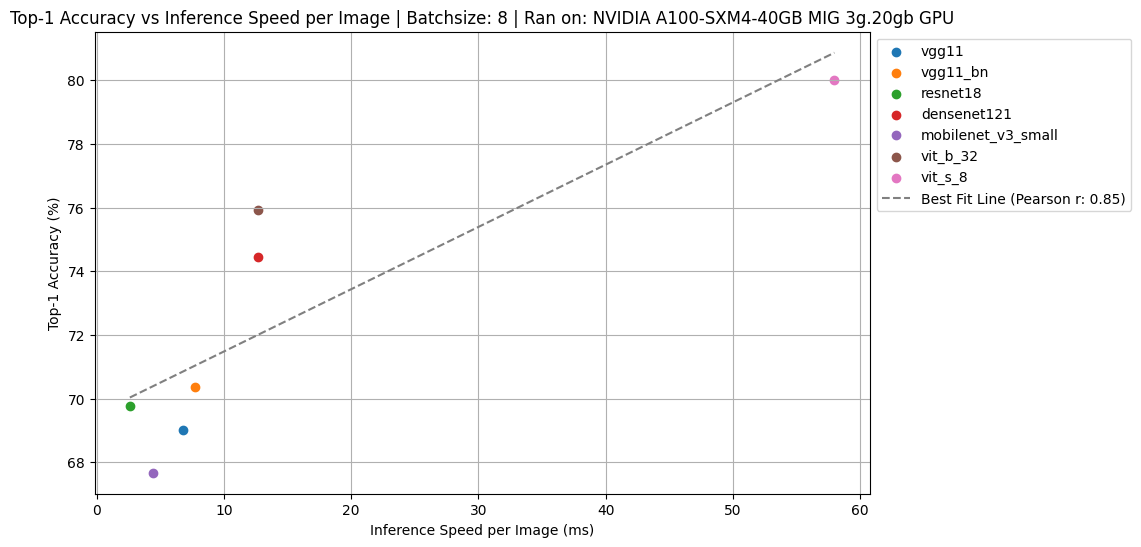

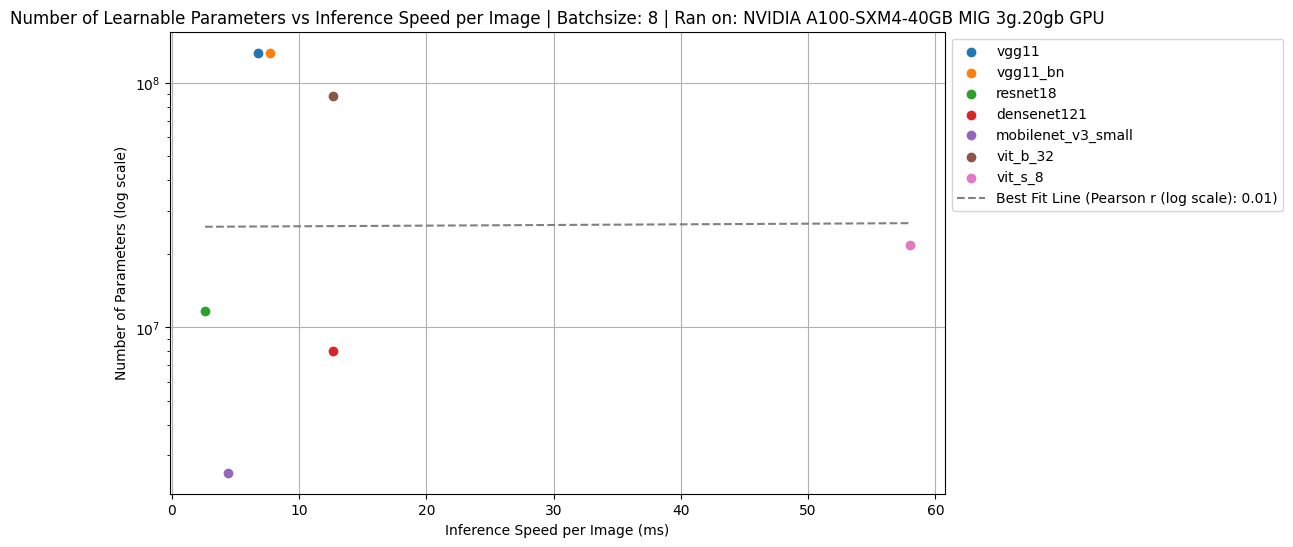

In [5]:
gpu = torch.cuda.get_device_name(torch.cuda.current_device())

# 1.1.a.i) Plot the top-1 accuracy vs inference speed per image
plt.figure(figsize=(10, 6))
plt.title(f"Top-1 Accuracy vs Inference Speed per Image | Batchsize: 8 | Ran on: {gpu} GPU")
plt.xlabel("Inference Speed per Image (ms)")
plt.ylabel("Top-1 Accuracy (%)")

# Plotting each model's data points individually
for name in model_data_a:
    x = model_data_a[name]['time']
    y = model_accs[name]
    plt.scatter(x, y, label=name)

# Line of best fit for accuracy vs speed
x_all = [model_data_a[name]['time'] for name in model_data_a]
y_all = [model_accs[name] for name in model_data_a]
coefficients = np.polyfit(x_all, y_all, 1)
polynomial = np.poly1d(coefficients)
ys = polynomial(x_all)

correlation = np.corrcoef(x_all, y_all)[0, 1]
line_label = f'Best Fit Line (Pearson r: {correlation:.2f})'
plt.plot(sorted(x_all), sorted(ys), color='grey', linestyle='--', label=line_label)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
# plt.savefig(f"a-i Accuracy vs Inference Speed on {gpu}.png")
# plt.close()

# 1.1.a.ii) Plot the number of learnable parameters vs inference speed per image
plt.figure(figsize=(10, 6))
plt.title(f"Number of Learnable Parameters vs Inference Speed per Image | Batchsize: 8 | Ran on: {gpu} GPU")
plt.xlabel("Inference Speed per Image (ms)")
plt.ylabel("Number of Parameters (log scale)")
plt.yscale('log')

# Plotting each model's data points individually
for name in model_data_a:
    x = model_data_a[name]['time']
    y = model_data_a[name]['n_params']
    plt.scatter(x, y, label=name)

# Line of best fit for speed vs parameters
x_all = [model_data_a[name]['time'] for name in model_data_a]
y_all = [model_data_a[name]['n_params'] for name in model_data_a]
coefficients = np.polyfit(x_all, np.log(y_all), 1)
polynomial = np.poly1d(coefficients)
ys = np.exp(polynomial(x_all))

log_y_all = np.log(y_all)
correlation = np.corrcoef(x_all, log_y_all)[0, 1]
line_label = f'Best Fit Line (Pearson r (log scale): {correlation:.2f})'
plt.plot(sorted(x_all), sorted(ys), color='grey', linestyle='--', label=line_label)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
# plt.savefig(f"a-ii Params vs Inference Speed on {gpu}.png")
# plt.close()

In [6]:
model_data_b = {}
for model_def in model_defs:
    name = model_def.__name__
    time_no_grad, vram_no_grad, n_params_no_grad = evaluate_model(model_def, no_grad=True)
    time_grad, vram_grad, n_params_grad = evaluate_model(model_def, no_grad=False)
    model_data_b[name] = {'time_no_grad': time_no_grad, 'time_grad': time_grad}

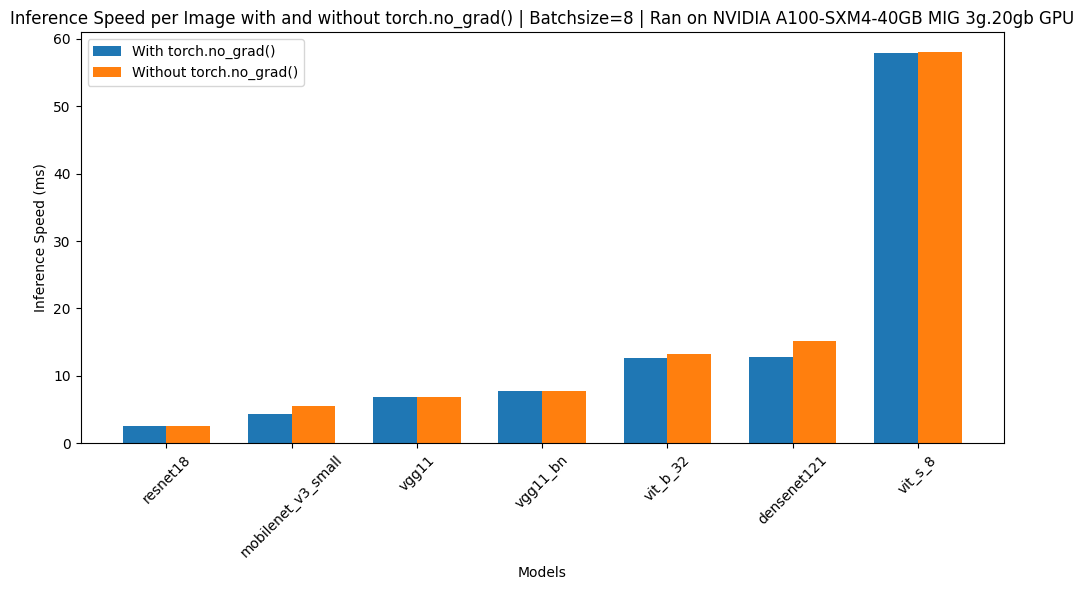

In [7]:
# 1.1.b) Inference speed per image for all models with and without gradients
models = list(model_data_b.keys())
times_no_grad = [model_data_b[name]['time_no_grad'] for name in models]
times_with_grad = [model_data_b[name]['time_grad'] for name in models]

# Sorting
times_no_grad, times_with_grad, models = zip(*sorted(zip(times_no_grad, times_with_grad, models)))

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, times_no_grad, width, label="With torch.no_grad()")
plt.bar(x + width/2, times_with_grad, width, label="Without torch.no_grad()")

plt.ylabel("Inference Speed (ms)")
plt.title(f"Inference Speed per Image with and without torch.no_grad() | Batchsize=8 | Ran on {torch.cuda.get_device_name(torch.cuda.current_device())} GPU")
plt.xticks(x, models, rotation=45)
plt.xlabel("Models")
plt.legend()

plt.tight_layout()

plt.show()
# plt.savefig(f"b Inference Speed with or without grad on {gpu}.png")
# plt.close()

In [8]:
model_data_c = {}
for model_def in model_defs:
    name = model_def.__name__
    _, vram_no_grad, n_params_no_grad = evaluate_model(model_def, no_grad=True, batch_size=64)
    _, vram_grad, n_params_grad = evaluate_model(model_def, no_grad=False, batch_size=64)
    model_data_c[name] = {'vram_no_grad': vram_no_grad, 'vram_grad': vram_grad}

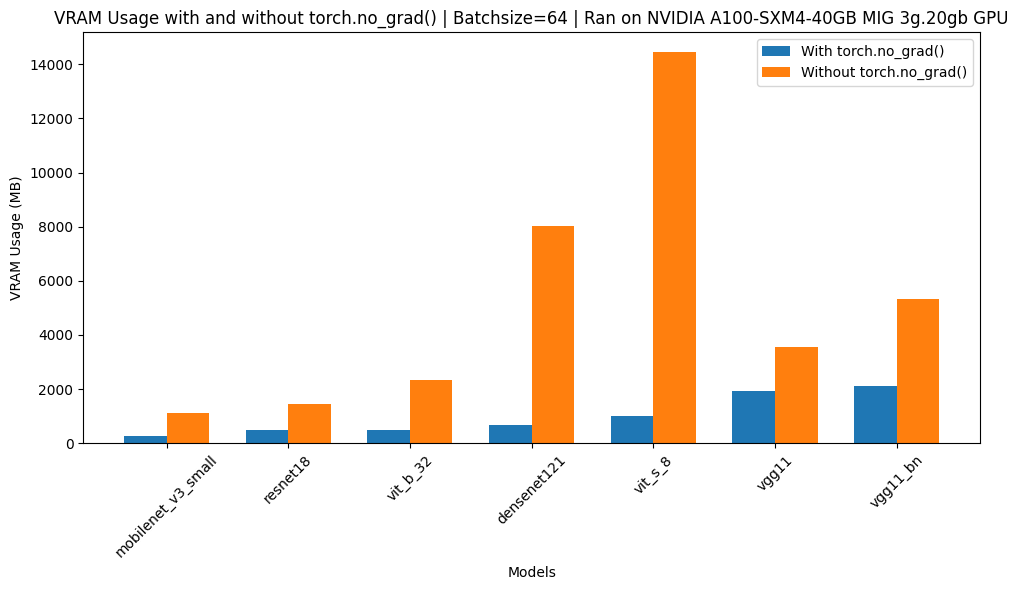

In [9]:
# 1.1.c) VRAM usage for all models with and without gradients
models = list(model_data_c.keys())
vrams_no_grad = [model_data_c[name]['vram_no_grad'] for name in models]
vrams_with_grad = [model_data_c[name]['vram_grad'] for name in models]

# Sorting
vrams_no_grad, vrams_with_grad, models = zip(*sorted(zip(vrams_no_grad, vrams_with_grad, models)))

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, vrams_no_grad, width, label="With torch.no_grad()")
plt.bar(x + width/2, vrams_with_grad, width, label="Without torch.no_grad()")
plt.ylabel("VRAM Usage (MB)")
plt.title(f"VRAM Usage with and without torch.no_grad() | Batchsize=64 | Ran on {torch.cuda.get_device_name(torch.cuda.current_device())} GPU")
plt.xticks(x, models, rotation=45)
plt.xlabel("Models")
plt.legend()

plt.tight_layout()

plt.show()
# plt.savefig(f"c VRAM Usage with or without grad on {gpu}.png")
# plt.close()